In [56]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import display
from joblib import dump
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             f1_score, make_scorer, roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier

from ml_model import PipelineManager
from utils.GPU_models import KerasClassifierModel, gpu_model_hub
from utils.preprocessing_utils import (clean_labs, clean_notas,
                                       clean_sociodemograficos, merge_classes,
                                       merge_labs_notas,
                                       word_count_feat_engineering)


In [57]:
set_config(display="diagram")
sns.set_style("darkgrid")
as_dual_class=False
target_feature = 'Código'
text_feature = 'Plan'
retrain_with_class_weight=False
add_gpu_prediction = False
consolidate_classes = False
cv = 3
n_iter = 16
n_jobs = -2

# False, 'oversample', or 'undersample'
balance_classes = 'oversample'
save_path = Path('data') / 'output' / 'best_model.pickle'

## Data load

In [58]:
df_notas = pd.read_csv('data/notas.csv', sep=';')
df_laboratorios = pd.read_csv('data/laboratorios.csv', sep=';')
df_sociodemografico = pd.read_csv('data/sociodemografico.csv', sep=';')

In [59]:
df_notas.head()

,IDRecord,Código,Nombre,Tipo,Plan
0,44600,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,- ORDENO TAR ABC +3TC +ATV/r - PROFILAXIS NO ...
1,45038,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,- TAF/FTC/EVG/C MIPRES POR 2 MESES 20200602158...
2,40391,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,usuaria la cual se ve pertinente seguimiento d...
3,106350,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,1. Se formula TAR (TDF/FTC+EFV) 2. S/S Paracl...
4,105840,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,EDUCACIÓN Se brinda retroalimentación con rel...


In [60]:
df_laboratorios.head()

,IDRecord,Codigo,Nombre,Fecha,Valor
0,95627,902045,TIEMPO DE PROTROMBINA (PT),22/02/2022 18:43,NaN
1,125572,902045,TIEMPO DE PROTROMBINA (PT),17/02/2022 13:41,NaN
2,55788,902045,TIEMPO DE PROTROMBINA (PT),22/06/2021 12:50,1.05
3,113766,902045,TIEMPO DE PROTROMBINA (PT),5/08/2021 12:11,NaN
4,44596,902045,TIEMPO DE PROTROMBINA (PT),5/08/2021 13:15,NaN


In [61]:
df_sociodemografico.head()

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+
3,307,88,Hombre,Ninguno de los anteriores,Zona Urbana,No reportado,NaN
4,325,94,Hombre,Ninguno de los anteriores,Zona Rural,Viudo/a,NaN


In [62]:
df_notas.head()

,IDRecord,Código,Nombre,Tipo,Plan
0,44600,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,- ORDENO TAR ABC +3TC +ATV/r - PROFILAXIS NO ...
1,45038,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,- TAF/FTC/EVG/C MIPRES POR 2 MESES 20200602158...
2,40391,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,usuaria la cual se ve pertinente seguimiento d...
3,106350,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,1. Se formula TAR (TDF/FTC+EFV) 2. S/S Paracl...
4,105840,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,EDUCACIÓN Se brinda retroalimentación con rel...


## Data Cleaning

In [63]:
df_sociodemografico = clean_sociodemograficos(df_sociodemografico)
df_laboratorios = clean_labs(df_laboratorios)
df_notas = clean_notas(df_notas)

### Merge the sociodemographic data with the medical notes dataset

In [64]:
df_merge = df_sociodemografico.merge(df_notas, how='inner', on='IDRecord')
df_merge

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre,Código,Nombre,Tipo,Plan
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,PACIENTE CONTINUA PROGRAMA NEFROPROTECCION S...
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,CONTINUA PROGRAMA CRONICOS.
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,1- CONTINUAR PAD 2 - RECOMENDACIONES DIETA HIP...
3,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,1- CONTINUAR PAD 2 - RECOMENDACIONES DIETA HIP...
4,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Nuevo,1- CONTINUAR PAD 2 - RECOMENDACIONES DIETA HIP...
...,...,...,...,...,...,...,...,...,...,...,...
140167,205218,28,Hombre,Ninguno de los anteriores,Zona Urbana,NaN,NaN,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,"explica acerca programa, recomienda adherencia..."
140168,205227,24,Hombre,Ninguno de los anteriores,Zona Urbana,Soltero,O+,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,Elaboracion duelo frente diagnostico. Reforz...
140169,205253,84,Hombre,Mestizo,Zona Urbana,Casado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,FUROATO MOMETASONA 1 SPRY NASAL CADA FOSA NASA...
140170,205577,62,Hombre,Mestizo,Zona Urbana,Desconocido,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Impresión Diagnóstica,CONTROL MEICO MES-INFECTOLOGIA VALORACIOJN IN...


## Feature Engineering

In [65]:
# Consolidate the classes
if consolidate_classes:
    df_merge = merge_classes(df_merge)

# Perform word count feature engineering
df_merge = word_count_feat_engineering(df_merge)

# Preprocess the lab data and merge it with the sociodemographic data
df_merge = merge_labs_notas(df_laboratorios, df_merge)

with pd.option_context('display.max_columns', None):
    display(df_merge.head(5))

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre,Código,Nombre,Tipo,Plan,acido,antibio,asintoma,cabeza,diabet,diet,gluco,hepat,insulin,keto,penici,preservativo,rpr,sable,serolo,sifili,test_reloj_orden,vih,top_lab_name,top_lab_avg_value,top_lab_max_value,top_lab_count,total_lab_count
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,PACIENTE CONTINUA PROGRAMA NEFROPROTECCION S...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CALCIO POR COLORIMETRÍA,8.0,8.0,1.0,8.0
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,CONTINUA PROGRAMA CRONICOS.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,1- CONTINUAR PAD 2 - RECOMENDACIONES DIETA HIP...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
3,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,1- CONTINUAR PAD 2 - RECOMENDACIONES DIETA HIP...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
4,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Nuevo,1- CONTINUAR PAD 2 - RECOMENDACIONES DIETA HIP...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN


## Label encoding

In [66]:
X = df_merge.drop(labels=[target_feature], axis=1)
y = df_merge[target_feature]
if as_dual_class:
    y = y.str[:2]

label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(y)

np.unique(y_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([  977,    94,  2614,  1970, 60586, 47408,  6278, 17437,  2808]))

## Train-test split

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, train_size=0.2, random_state=42, stratify=y_labels)

## Class Balancing

In [68]:
if balance_classes == 'oversample':
    # Using a naive oversampling approach
    sampler = RandomOverSampler(random_state=42)
    X_train, y_train = sampler.fit_resample(X_train, y_train)
elif balance_classes == 'undersample':
    # Using a naive oversampling approach
    sampler = RandomOverSampler(random_state=42)
    X_train, y_train = sampler.fit_resample(X_train, y_train)
np.unique(y_train, return_counts=True) # Let's check the number of samples per label

## Further feature engineering

In [69]:
# embedding = "nnlm-es-dim128"
embedding = "nnlm-es-dim128-with-normalization"
# embedding = "universal"

if add_gpu_prediction:
    model_function = gpu_model_hub
    clf = KerasClassifierModel(
        build_fn=model_function,
        class_number=len(df_notas[target_feature].unique()),
        embedding = embedding,
        epochs=400,
        batch_size=400,
        verbose=10,
    )

    clf.fit(X_train[text_feature], y_train)
    clf.plot_learning_curves('data/output/gpu_model')

In [70]:
if add_gpu_prediction:
    y_pred = clf.predict(X_test[text_feature])
    display(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose())

In [71]:
if add_gpu_prediction:
    X_pred = clf.predict(df_merge[text_feature])
    df_merge['GPU_prediction'] = X_pred
    df_merge

## Hyperparameter Setup

In [72]:
numerical_features = list(set(['Edad', 'top_lab_avg_value', 'top_lab_max_value', 'top_lab_count', 'total_lab_count'] + list(df_merge.drop(columns='IDRecord').select_dtypes(include='int64').columns)))
categorical_features = ['Genero', 'GrupoEtnico', 'AreaResidencial', 'EstadoCivil', 'TSangre', 'Tipo', 'top_lab_name']

In [73]:
if 'GPU_prediction' in df_merge:
    categorical_features.append('GPU_prediction')

pipeline = PipelineManager(estimator="classifier")
pipeline.set_numerical_features(numerical_features)
pipeline.set_categorical_features(categorical_features)
pipeline.set_text_feature(text_feature)
pipeline.set_basic_pipeline()

# param_grid = {
#     "n_estimators": np.linspace(1, 100, 10, dtype=int),
#     "max_depth": list(np.linspace(1, 10, 5, dtype=int)) + [None],
#     "bootstrap": [True, False],
# }
# estimator = RandomForestClassifier()
# pipeline.add_estimator(estimator, param_grid)


param_grid = {
    "n_estimators": np.linspace(1, 200, 10, dtype=int),
    "max_depth": list(np.linspace(2, 10, 5, dtype=int)) + [None],
    "eta":  np.linspace(0.01, 0.5, 10, dtype=float),
    "min_child_weight": np.linspace(0.5, 20, 5, dtype=float),
    "gamma": np.linspace(0, 1, 5, dtype=float),
    "subsample": np.linspace(0.1, 1, 5, dtype=float),
    "colsample_bytree": np.linspace(0.2, 1, 5, dtype=float),
    "reg_lambda": np.linspace(0, 12, 10, dtype=float),
    "reg_alpha": np.linspace(0, 12, 10, dtype=float),
    # "scale_pos_weight": np.linspace(0.1, 500, 100, dtype=float),
}
estimator = XGBClassifier()
pipeline.add_estimator(estimator, param_grid)

param_grid = {
}
estimator = PassiveAggressiveClassifier()
pipeline.add_estimator(estimator, param_grid)


param_grid = {
}
estimator = SGDClassifier()
pipeline.add_estimator(estimator, param_grid)

param_grid = {
    'C': np.linspace(0, 2, 10, dtype=float),
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma':['auto', 'scale'],
    'class_weight': ['balanced', None],
    'coef0':np.linspace(0, 2, 10, dtype=float),
    'degree':np.linspace(1, 5, 5, dtype=int),
}
estimator = SVC()
pipeline.add_estimator(estimator, param_grid)


pipeline.pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Genero', 'GrupoEtnico',
                                                   'AreaResidencial',
                                                   'EstadoCivil', 'TSangre',
                                                   'Tipo', 'top_lab_name']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   Simp...
                                                                   CountVectorizer(stop_words=['de',
                                                                                               'la',
                                                                                               'que',
                                                                                               'el',
                                                                                               'en',
                                                                                               'y',
                                                                                               'a',
                                                                                               'los',
                                                                                               'del',
                                                                                               'se',
                                                                                               'las',
                                                                                               'por',
                                                                                               'un',
                                                                                               'para',
                                                                                               'con',
                                                                                               'no',
                                                                                               'una',
                                                                                               'su',
                                                                                               'al',
                                                                                               'lo',
                                                                                               'como',
                                                                                               'más',
                                                                                               'pero',
                                                                                               'sus',
                                                                                               'le',
                                                                                               'ya',
                                                                                               'o',
                                                                                               'este',
                                                                       

## Hyperparameter tuning

In [74]:
sample_weight = compute_sample_weight(
    class_weight='balanced',
    y=df_merge[target_feature])

scoring = {
    "Accuracy": "balanced_accuracy",
    "Weighted_F1": make_scorer(f1_score, average='weighted'),
    # 'roc_auc':make_scorer(roc_auc_score, average='weighted'),
    }
best_model = pipeline.find_best_model(
    X_train,
    y_train,
    cv=cv,
    n_iter=n_iter,
    n_jobs=n_jobs,
    scoring=scoring,
    random_state=7,
    refit='Weighted_F1',
    verbose = 1,
    )

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvier

In [75]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Genero', 'GrupoEtnico',
                                                   'AreaResidencial',
                                                   'EstadoCivil', 'TSangre',
                                                   'Tipo', 'top_lab_name']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNI...
                               eval_metric=None, gamma=0.75, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.282222211, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=10, max_leaves=0, min_child_weight=0.5,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, ...))])

In [76]:
with pd.option_context('display.max_columns', None):
    display(pipeline.cv_results.sort_values(by=["rank_test_Weighted_F1"]).head(30))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__text__vectorizer,param_preprocessor__text__tfidf,param_preprocessor__numerical__scaler,param_preprocessor__numerical__imputer,param_feature_selector,param_estimator__subsample,param_estimator__reg_lambda,param_estimator__reg_alpha,param_estimator__n_estimators,param_estimator__min_child_weight,param_estimator__max_depth,param_estimator__gamma,param_estimator__eta,param_estimator__colsample_bytree,param_estimator,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_test_Weighted_F1,split1_test_Weighted_F1,split2_test_Weighted_F1,mean_test_Weighted_F1,std_test_Weighted_F1,rank_test_Weighted_F1
9,1940.958400,106.856141,424.880712,64.533297,"CountVectorizer(ngram_range=(2, 2),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",Normalizer(),KNNImputer(),SelectFromModel(estimator=Ridge()),1.0,4.0,9.333333,100,0.5,10,0.75,0.282222,0.4,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.942230,0.941762,0.948337,0.944110,0.002995,1,0.941318,0.940566,0.947594,0.943159,0.003151,1
7,2338.605954,50.912413,483.145756,19.244335,"CountVectorizer(ngram_range=(3, 3),\n ...",TfidfTransformer(norm='l1'),Normalizer(),KNNImputer(),VarianceThreshold(),0.55,10.666667,4.0,45,5.375,10,0.75,0.5,1.0,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.929631,0.929135,0.931804,0.930190,0.001159,2,0.928044,0.927354,0.930527,0.928642,0.001363,2
1,2175.205539,109.130403,36.551559,0.573089,"CountVectorizer(ngram_range=(1, 3),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",RobustScaler(),SimpleImputer(strategy='most_frequent'),SelectFromModel(estimator=Ridge()),0.775,12.0,0.0,67,10.25,10,1.0,0.336667,0.4,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.901846,0.907513,0.909053,0.906137,0.003099,3,0.898242,0.904201,0.905986,0.902810,0.003311,3
13,1994.988117,334.040888,23.424193,9.444163,"CountVectorizer(ngram_range=(1, 3),\n ...",TfidfTransformer(),Normalizer(),SimpleImputer(strategy='most_frequent'),VarianceThreshold(),0.325,4.0,8.0,34,15.125,10,1.0,0.391111,1.0,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.883359,0.884350,0.886358,0.884689,0.001247,4,0.879227,0.880193,0.882793,0.880737,0.001506,4
12,1760.886992,162.371089,25.663240,6.191963,"CountVectorizer(ngram_range=(1, 3),\n ...",TfidfTransformer(norm='l1'),StandardScaler(),SimpleImputer(strategy='most_frequent'),SelectFromModel(estimator=Ridge()),0.775,8.0,12.0,45,0.5,8,0.5,0.227778,0.6,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.870402,0.872108,0.871255,0.871255,0.000696,5,0.863180,0.865449,0.864681,0.864437,0.000942,5
6,3354.904840,67.023291,464.521369,43.309153,"CountVectorizer(ngram_range=(3, 3),\n ...",TfidfTransformer(),Normalizer(),KNNImputer(),VarianceThreshold(),1.0,8.0,0.0,89,5.375,10,0.75,0.01,0.6,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.816704,0.825920,0.822123,0.821582,0.003782,6,0.810813,0.819949,0.816631,0.815798,0.003776,6
3,543.405929,21.628732,14.823724,2.754477,"CountVectorizer(ngram_range=(3, 3),\n ...",TfidfTransformer(sublinear_tf=True),Normalizer(),SimpleImputer(),SelectFromModel(estimator=ElasticNet()),1.0,8.0,12.0,45,15.125,4,0.5,0.227778,0.8,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.746032,0.747215,0.736761,0.743336,0.004674,7,0.736620,0.736809,0.726611,0.733347,0.004763,7
2,254.245001,42.285798,17.035312,0.640455,"CountVectorizer(ngram_range=(1, 2),\n ...",TfidfTransformer(norm='l1'),MinMaxScaler(),SimpleImputer(strategy='most_frequent'),VarianceThreshold(),0.1,4.0,0.0,12,0.5,None,0.75,0.064444,0.8,"XGBClassifier(

In [77]:
pipeline.cv_results.sort_values(by=["rank_test_Weighted_F1"])[[
    'rank_test_Weighted_F1',
    'rank_test_Accuracy',
    'mean_fit_time',
    'param_estimator',
    'param_preprocessor__text__vectorizer',
    'param_preprocessor__text__tfidf',
    'param_preprocessor__numerical__scaler',
    'param_preprocessor__numerical__imputer', 'param_feature_selector',
    'mean_test_Accuracy',
    'mean_test_Weighted_F1'
    ]]

,rank_test_Weighted_F1,rank_test_Accuracy,mean_fit_time,param_estimator,param_preprocessor__text__vectorizer,param_preprocessor__text__tfidf,param_preprocessor__numerical__scaler,param_preprocessor__numerical__imputer,param_feature_selector,mean_test_Accuracy,mean_test_Weighted_F1
9,1,1,1940.958400,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(2, 2),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",Normalizer(),KNNImputer(),SelectFromModel(estimator=Ridge()),0.944110,0.943159
7,2,2,2338.605954,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(3, 3),\n ...",TfidfTransformer(norm='l1'),Normalizer(),KNNImputer(),VarianceThreshold(),0.930190,0.928642
1,3,3,2175.205539,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(1, 3),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",RobustScaler(),SimpleImputer(strategy='most_frequent'),SelectFromModel(estimator=Ridge()),0.906137,0.902810
13,4,4,1994.988117,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(1, 3),\n ...",TfidfTransformer(),Normalizer(),SimpleImputer(strategy='most_frequent'),VarianceThreshold(),0.884689,0.880737
12,5,5,1760.886992,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(1, 3),\n ...",TfidfTransformer(norm='l1'),StandardScaler(),SimpleImputer(strategy='most_frequent'),SelectFromModel(estimator=Ridge()),0.871255,0.864437
6,6,6,3354.904840,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(3, 3),\n ...",TfidfTransformer(),Normalizer(),KNNImputer(),VarianceThreshold(),0.821582,0.815798
3,7,7,543.405929,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(3, 3),\n ...",TfidfTransformer(sublinear_tf=True),Normalizer(),SimpleImputer(),SelectFromModel(estimator=ElasticNet()),0.743336,0.733347
2,8,8,254.245001,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(1, 2),\n ...",TfidfTransformer(norm='l1'),MinMaxScaler(),SimpleImputer(strategy='most_frequent'),VarianceThreshold(),0.685676,0.668525
0,9,9,281.188761,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(1, 3),\n ...",TfidfTransformer(sublinear_tf=True),Normalizer(),SimpleImputer(strategy='most_frequent'),SelectFromModel(estimator=Ridge()),0.600790,0.611464
8,10,10,197.103409,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(1, 2),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",StandardScaler(),SimpleImputer(strategy='median'),SelectFromModel(estimator=Ridge()),0.545689,0.544771


In [78]:
# Retrain the model using a sample-weighting mechanism to try to compensate for the dataset imbalance
if retrain_with_class_weight:
    from sklearn.utils.class_weight import compute_sample_weight
    sample_weights = compute_sample_weight(
        class_weight='balanced',
        y=y_train,
    )

    best_model.fit(X_train, y_train, estimator__sample_weight=sample_weights)

## Scoring

In [79]:
score = pipeline.score(X_test, y_test)
score

,ROC_AUC,accuracy,balanced_accuracy,micro_f1_score,macro_f1_score,weighted_f1_score,confusion_matrix,confusion_matrix_normalized,classification_report
0,0.960754,0.785996,0.735845,0.785996,0.738391,0.786019,"[[501, 2, 6, 0, 200, 62, 1, 5, 5], [0, 63, 1, ...","[[0.004467709429452995, 1.783516738304589e-05,...",precision recall f1-score ...


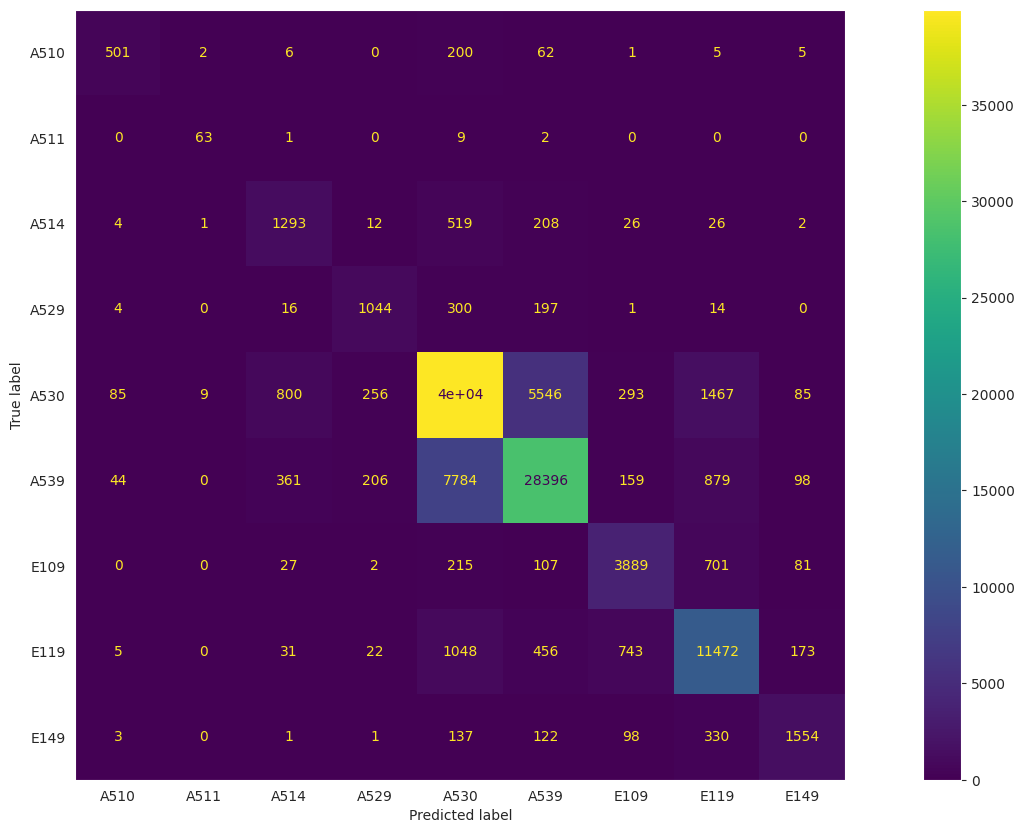

In [80]:
labels_decoded = label_encoder.inverse_transform(best_model['estimator'].classes_)

with sns.axes_style("dark"):
    fig, ax = plt.subplots(figsize=(20,10))
    disp = ConfusionMatrixDisplay(confusion_matrix=score.loc[0,'confusion_matrix'],
                                display_labels=labels_decoded)
    disp.plot(ax=ax, cmap='viridis')
    plt.show()

In [81]:
score.loc[0,'classification_report'].round(2).rename(index={str(class_label):label for class_label, label in zip(best_model['estimator'].classes_, labels_decoded)})

,precision,recall,f1-score,support
A510,0.78,0.64,0.70,782.00
A511,0.84,0.84,0.84,75.00
A514,0.51,0.62,0.56,2091.00
A529,0.68,0.66,0.67,1576.00
A530,0.80,0.82,0.81,48469.00
A539,0.81,0.75,0.78,37927.00
E109,0.75,0.77,0.76,5022.00
E119,0.77,0.82,0.80,13950.00
E149,0.78,0.69,0.73,2246.00
accuracy,0.79,0.79,0.79,0.79


## Saving the best performing model

In [82]:
save_path.parent.mkdir(parents=True, exist_ok=True)
dump(best_model, str(save_path))
dump(score, str(save_path.parent / f'best_model_score{save_path.suffix}'))

['data/output/best_model_score.pickle']